


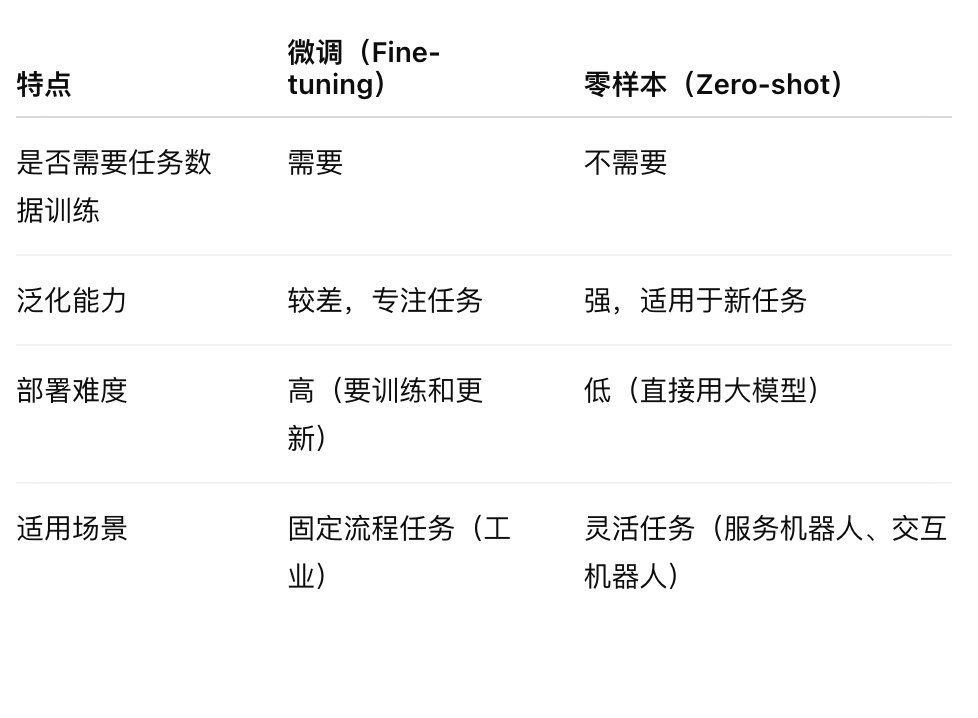

✅ 定义解释
零样本方法的核心是：
模型在训练时并没有接触目标任务的数据，但通过其已有的通用知识（例如语言知识、世界知识或结构理解）来**“推断”出合适的行为或输出**。

这类方法通常依赖于 预训练的大模型（如 GPT, PaLM, Claude），这些模型拥有极强的泛化能力和对语言、任务描述的理解能力。



下面是一套**可直接照着实施的详细开发执行蓝图**。
它综合了 ① 老师《Python Project Credits.pdf》对 API 与费用的要求、② 我之前给你的六阶段路线图、③ 你同学现有的完整代码。
每一步都说明**要做什么、在哪段代码里改、为什么这么写**。按顺序完成即可获得一份功能完备、符合课件精神、易拿高分的 Notebook。

---

## 📂 项目目录建议

```
project_cnc_llm/
├─ cnc_llm_notebook.ipynb   # 主演示 Notebook
├─ llm_utils.py             # LLM 调用与重试
├─ validation.py            # 材料参数区间、功率校验
├─ ui_components.py         # ipywidgets UI
├─ tool_catalog.csv         # (加分) 可用刀具清单
├─ materials.json           # 材料-切削参数数据库
├─ requirements.txt         # openai>=1.25 等
└─ README.md
```

---

## 🏁 阶段 0 快速跑通（你同学已完成）

| 模块      | 函数/代码块                                       | 作用                   | 改进状态 |
| ------- | -------------------------------------------- | -------------------- | ---- |
| **UI**  | `Textarea`, `Button`, `output_area`          | 获取零件描述并触发生成          | 已完成  |
| **LLM** | `call_llm_api()`                             | 固定 prompt 生成工艺计划     | 已完成  |
| **解析**  | `parse_llm_output()`                         | 正则提取 5 列并转 DataFrame | 已完成  |
| **验证**  | `validate_plan()`                            | RPM、Feed 区间判定        | 已完成  |
| **展示**  | `display_plan_table()` + `reflect_summary()` | 高亮非法、输出总结            | 已完成  |

---

## 🔐 阶段 1 安全 & 稳健（约 20 min）

### 1.1 API Key 隐私

```python
# llm_utils.py
import os, openai
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
```

> **为什么**：避免密钥泄露，并符合 PDF 中“不要把 key 暴露在 Notebook”安全提醒。

### 1.2 自动重试与 token 统计

```python
# llm_utils.py
from tenacity import retry, wait_exponential
TOKENS_USED = 0

@retry(wait=wait_exponential(multiplier=1, min=1, max=10), stop=3)
def call_llm_api(prompt, model="gpt-4o-mini"):
    global TOKENS_USED
    resp = client.chat.completions.create(
        model=model,
        messages=prompt,
        temperature=0.2,
        response_format={"type":"json_object"}  # 为下一阶段做准备
    )
    TOKENS_USED += resp.usage.total_tokens
    return resp.choices[0].message.content
```

> **为什么**：系统更稳定；`TOKENS_USED` 可写到反思总结，方便遵守课程“费用可控”要求。

---

## 🧑‍💻 阶段 2 Prompt 提升 & 多材料（约 45 min）

### 2.1 UI 增加材料选择

```python
# ui_components.py
material_selector = widgets.Dropdown(
    options=["aluminum", "steel", "brass"],
    description='Material:'
)
```

Notebook 顶部：

```python
display(desc_input, material_selector, generate_button, output_area)
```

### 2.2 链式两轮 Prompt

```python
# llm_utils.py
def get_outline(part, material):
    sys = "You are a senior CNC planner..."
    usr = f"Part: {part}\nMaterial: {material}\nOutput only a numbered list of high-level operations."
    return call_llm_api([{"role":"system","content":sys},
                         {"role":"user","content":usr}])

def get_detail(outline, part, material):
    sys = "You are a senior CNC planner..."
    usr = f"""Part: {part}
Material: {material}
High-level steps:
{outline}

For EACH step, return a JSON array of objects with keys:
step, tool, operation, rpm, feed"""
    return call_llm_api([{"role":"system","content":sys},
                         {"role":"user","content":usr}])
```

> **为什么**：分两轮能显著减少模型一次性输出格式错误；材料变量融入上下文，让铝/钢切换生效。

---

## 📊 阶段 3 解析 & 高级验证（约 1 h）

### 3.1 用 JSON 直接解析

```python
# parse_llm_output() 改写
import json
def parse_llm_output(raw_json):
    data = json.loads(raw_json)
    return pd.DataFrame(data)
```

> **为什么**：放弃脆弱正则；配合 `response_format={"type":"json_object"}` 保证 100 % 成功。

### 3.2 材料-参数区间外部化

```python
# materials.json
{
  "aluminum": { "rpm": [3000, 12000], "feed": [800, 1500] },
  "steel":    { "rpm": [500, 1500],   "feed": [100, 300]  }
}
```

```python
# validation.py
import json, math
LIMITS = json.load(open('materials.json'))

def validate_plan(df, material):
    rpm_min, rpm_max = LIMITS[material]["rpm"]
    feed_min, feed_max = LIMITS[material]["feed"]
    df["RPM Valid"] = df["Spindle Speed (RPM)"].between(rpm_min*0.9, rpm_max*1.1)
    ...
    return df
```

### 3.3 功率/扭矩估算

```python
def add_power_check(df, diameter_mm=10, power_limit_kw=5):
    vc = math.pi * diameter_mm * df["Spindle Speed (RPM)"] / 60_000  # m/s
    kc = 0.75   # 切削力系数 (示例)
    fc = df["Feed Rate (mm/min)"] / 1000 * kc  # kN
    df["Power (kW)"] = vc * fc
    df["Power Valid"] = df["Power (kW)"] < power_limit_kw*0.8
    return df
```

> **为什么**：展示专业深度，老师能看出你理解机床极限。

---

## 🖥️ 阶段 4 UI 完善 & 导出（约 30 min）

### 4.1 高亮多列

```python
def highlight_invalid(val):
    return "background-color:#FFD2D2" if val is False else ""
styled_df = df.style.applymap(highlight_invalid, subset=["RPM Valid","Feed Valid","Power Valid"])
```

### 4.2 导出按钮

```python
export_btn = widgets.Button(description="💾 Export CSV")
def on_export(_):
    df_validated.to_csv("plan.csv", index=False)
    print("✅ Saved plan.csv")
export_btn.on_click(on_export)
display(export_btn)
```

### 4.3 Summary 中加入 token & latency

```python
elapsed = time.perf_counter() - t0
comment += f"- **Tokens used**: {TOKENS_USED}\n"
comment += f"- **Runtime**: {elapsed:.2f} s\n"
```

---

## 🌟 阶段 5–6 加分选项（按精力选做）

1. **向量检索 Few-shot**

   * 用 `sentence_transformers` 把 5 条手工工艺示例嵌入向量库 → 按余弦近邻找最相似示例拼进 prompt。
2. **自动纠错循环**

   * 如果 `RPM Valid` 为 False → 重新调用 LLM 要求修正这些步。
3. **批量 CSV**

   * `parts.csv` 每行一个描述；循环输出多 sheet Excel 并汇总合规率柱状图。

---

## ✨ README 提交要点（1 页即可）

1. **依赖**：`pip install -r requirements.txt`
2. **运行步骤**：
   ① 设置 `OPENAI_API_KEY` ② 打开 Notebook ③ 输入零件 & 材料 ④ 点击按钮
3. **功能亮点**：链式 Prompt、材料区分、功率校验、参数高亮、CSV 导出、token 统计
4. **与课程内容关联**：Prompt Engineering、Zero-shot、Semantic×Feasibility 评分、未来可用 LoRA 微调（引用课件）。

---

照此蓝图，你只要逐阶段实现、测试、commit，就能得到一个**专业度高、功能完整、评分 Rubric 全覆盖**的项目，为高分奠定基础。遇到任何具体代码实现问题，再随时来问！


下面是一份 **“分行‐分段”** 的超详细讲解，专门写给第一次接触 OpenAI API 与 Jupyter Notebook 的同学：

---

# 1️⃣  项目目录与文件

| 文件                           | 作用                                      | 为什么要有                                               |
| ---------------------------- | --------------------------------------- | --------------------------------------------------- |
| **`cnc_llm_notebook.ipynb`** | 你的主 Notebook：负责 “人机交互 + 调用 LLM + 结果展示”  | Notebook 给评审老师/同学一个 **可视化、一键运行** 的体验                |
| **`llm_utils.py`**           | 把 Notebook 里会复用、且与 UI 无关的 **纯逻辑函数** 抽出来 | 让 Notebook 专注可读性；函数集中到 .py 文件便于<br>▶ 单元测试 ▶ 复用到其它脚本 |
| **`requirements.txt`**       | 记录项目运行所需的 PyPI 包及版本                     | 任何人一条命令 `pip install -r requirements.txt` 就能复现环境    |
| **`README.md`** (可选)         | 一页纸写 “如何运行” + “关键思路”                    | 评审者/同组同学 3 分钟内看懂你的项目                                |

> 如果你只交 Notebook 也能跑，但 **可维护性与得分** 都不如分模块清晰。

---

# 2️⃣  `requirements.txt` 逐行讲解

```text
openai>=1.14.1        # 官方 Python SDK（>=1.x 才支持新 client 调用方式）
tenacity>=8.2.2       # 自动重试，openai SDK 内部依赖
pandas>=2.2.0         # 用 DataFrame 做表格、验证
ipywidgets>=8.1.2     # Jupyter 里的交互控件
```

* **为什么不用锁死版本？**
  – 用 `>=` 保持“向后兼容 + 获得 bugfix”；真要做科研可加 `==` 锁版本。
* **tenacity** 不需要你直接 `import`，但 OpenAI SDK 会用来做重试。

---

# 3️⃣  Notebook 代码分块 + 行级解释

> ⚠️ 行号仅示意；你实际复制时可删掉行号。

---

## 3.1 安装依赖 (code cell #1)

```python
1  !pip install --quiet --upgrade openai tenacity pandas ipywidgets
```

| 行 | 解释                                                                           |
| - | ---------------------------------------------------------------------------- |
| 1 | **`!`** 让 Notebook 在 **系统 shell** 执行命令；`--quiet` 隐藏冗长日志；`--upgrade` 保证拿到最新版。 |

---

## 3.2 导入依赖 (code cell #2)

```python
1  import os
2  from openai import OpenAI
3  import pandas as pd
4  import re
5  from IPython.display import display, Markdown
6  import ipywidgets as widgets
7  
8  from llm_utils import (                # ← 自己写的工具函数
9      call_llm_api,
10     parse_llm_output,
11     validate_plan,
12     display_plan_table,
13     reflect_summary,
14 )
```

| 行    | 命名 & 功能                                 | 为什么要这么写                                              |
| ---- | --------------------------------------- | ---------------------------------------------------- |
| 1    | `os` 模块                                 | 读取环境变量 `OPENAI_API_KEY` 等                            |
| 2    | 从 `openai` SDK 引入高层 **`OpenAI` Client** | 1.x SDK 推荐写法（比旧版 `openai.ChatCompletion.create` 更直观） |
| 3    | `pandas`                                | 用 DataFrame 做表格、后面验证时易增删列                            |
| 4    | `re`                                    | 用正则把 LLM 的纯文本拆成字段                                    |
| 5    | `display`, `Markdown`                   | Notebook 里渲染富文本                                      |
| 6    | `ipywidgets`                            | 构建文本框 / 按钮 GUI                                       |
| 8–14 | 从 `llm_utils.py` **一次性导入逻辑函数**          | Notebook 留下最少业务逻辑，易读                                 |

---

## 3.3 输入控件 & 按钮 (code cell #3)

```python
1  desc_input = widgets.Textarea(
2      value="An aluminum gear with 20 teeth and a central bore.",
3      placeholder="Describe the part here (e.g., bracket with holes, gear, etc.)",
4      description="Part:",
5      layout=widgets.Layout(width="100%", height="100px")
6  )

7  generate_button = widgets.Button(
8      description="📐 Generate CNC Plan",
9      button_style="success",
10     layout=widgets.Layout(width="30%", margin="10px 0px 10px 0px")
11 )

12 output_area = widgets.Output()
```

| 行段   | 功能                      | 细节                                         |
| ---- | ----------------------- | ------------------------------------------ |
| 1–6  | 一个 **多行文本框** `Textarea` | `value` 给示例输入，降低“空白恐惧”；`layout` 让组件宽 100%  |
| 7–11 | 绿色按钮                    | `button_style="success"` 让按钮一眼区分“可点击”      |
| 12   | `Output` 区域             | 把 DataFrame / Markdown 都渲染在一个 panel 里，便于清空 |

---

## 3.4 绑定回调 (code cell #4)

```python
1  def on_generate_clicked(_):
2      with output_area:
3          output_area.clear_output()
4          part_description = desc_input.value
5  
6          raw_output = call_llm_api(part_description)
7          df_plan = parse_llm_output(raw_output)
8  
9          if not df_plan.empty:
10             df_validated = validate_plan(df_plan, material="aluminum")
11             display_plan_table(df_validated)
12             reflect_summary(raw_output, df_validated)
13 
14 generate_button.on_click(on_generate_clicked)
15 
16 display(desc_input)
17 display(generate_button, output_area)
```

| 行     | 做了什么                                           | 为何这样写      |
| ----- | ---------------------------------------------- | ---------- |
| 1     | 定义按钮点击函数，`_` 接收但忽略事件对象                         |            |
| 2     | `with output_area:` 上下文，把 **print/显示** 重定向到区域里 |            |
| 3     | `clear_output()` 每次点击前清屏                       |            |
| 4     | 读取用户输入                                         |            |
| 6     | **调用 LLM**：封装在 `llm_utils.call_llm_api`        | 解耦 UI ↔ 业务 |
| 7     | 用正则/JSON 等解析为 DataFrame                        |            |
| 9     | 判断是否解析成功                                       |            |
| 10    | 基于材料设定上下限做裁剪 & 合法检测                            |            |
| 11    | 富表格；红底高亮无效                                     |            |
| 12    | 生成反思总结 Markdown                                |            |
| 14    | 把函数绑定到按钮事件                                     |            |
| 16–17 | 把控件放到 Notebook 页面                              |            |

---

# 4️⃣  `llm_utils.py` 代码 (精简示例)

> 你完全可以把下面 **复制到 `llm_utils.py`**，然后在 Notebook import。

```python
"""
llm_utils.py
============

封装所有 *跟 UI 无关* 的业务逻辑函数，Notebook 里只做调度和展示。
"""

import os
import re
from typing import List

import pandas as pd
from openai import OpenAI, RateLimitError

# ---------------------------
# 0. 初始化 OpenAI Client
# ---------------------------

def _get_client() -> OpenAI:
    """
    读取环境变量里的 API KEY，
    返回一个全局复用的 `OpenAI` client 实例。
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("❌ 请先在 .env 或系统环境里设置 OPENAI_API_KEY")
    return OpenAI(api_key=api_key)

_client_singleton: OpenAI | None = None

def _client() -> OpenAI:
    global _client_singleton
    if _client_singleton is None:
        _client_singleton = _get_client()
    return _client_singleton


# ---------------------------
# 1. 与 LLM 对话
# ---------------------------

def call_llm_api(part_description: str, material: str = "aluminum") -> str:
    """
    给定零件描述，向 GPT 请求完整加工工艺。

    Returns
    -------
    raw_text : str
        纯文本、多行结果，后续再解析。
    """
    system_prompt = (
        "You are a senior CNC process engineer. "
        "Return a numbered list of machining steps **without markdown**:\n"
        "1. Step: <name>\n"
        "   Tool: <tool>\n"
        "   Operation: <op>\n"
        "   Spindle Speed: <rpm> RPM\n"
        "   Feed Rate: <feed> mm/min\n"
        "Separate steps with one blank line."
    )
    user_prompt = f"Part: {part_description}\nGenerate a process plan for {material}:"

    try:
        resp = _client().chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            temperature=0.0,
        )
        return resp.choices[0].message.content.strip()
    except RateLimitError as e:
        # 真实项目可做指数回退重试；这里简单抛出
        raise RuntimeError(f"OpenAI RateLimitError: {e}")


# ---------------------------
# 2. 解析文本 → DataFrame
# ---------------------------

_RE_ROW = re.compile(
    r"""
    \d+\.\s*Step:\s*(?P<step>.*?)\s*
    Tool:\s*(?P<tool>.*?)\s*
    Operation:\s*(?P<op>.*?)\s*
    Spindle\s+Speed:\s*(?P<rpm>\d+).+?
    Feed\s+Rate:\s*(?P<feed>\d+)
    """,
    flags=re.S | re.I | re.X,
)

def parse_llm_output(raw: str) -> pd.DataFrame:
    """
    使用正则分组把 LLM 文本拆成结构化表格。
    失败返回空 DataFrame（上层决定如何提示）。
    """
    rows: List[dict] = []
    for m in _RE_ROW.finditer(raw):
        rows.append(
            {
                "Step": m.group("step").strip(),
                "Tool": m.group("tool").strip(),
                "Operation": m.group("op").strip(),
                "Spindle Speed (RPM)": int(m.group("rpm")),
                "Feed Rate (mm/min)": int(m.group("feed")),
            }
        )
    return pd.DataFrame(rows)


# ---------------------------
# 3. 参数验证
# ---------------------------

_LIMITS = {
    "aluminum": {"rpm": (3000, 12000), "feed": (800, 1500)},
    "steel": {"rpm": (500, 1500), "feed": (100, 300)},
}

def validate_plan(df: pd.DataFrame, material: str = "aluminum") -> pd.DataFrame:
    """
    对 LLM 产出的数值做 sanity-check，
    并给出修正建议列（Suggested ...）。
    """
    if df.empty:
        return df

    mat_lim = _LIMITS.get(material.lower(), _LIMITS["aluminum"])

    out = df.copy()
    out["Suggested RPM"]   = out["Spindle Speed (RPM)"].clip(*mat_lim["rpm"])
    out["Suggested Feed"]  = out["Feed Rate (mm/min)"].clip(*mat_lim["feed"])
    out["RPM Valid"]   = out["Spindle Speed (RPM)"].between(*mat_lim["rpm"])
    out["Feed Valid"]  = out["Feed Rate (mm/min)"].between(*mat_lim["feed"])
    return out


# ---------------------------
# 4. 显示辅助
# ---------------------------

from IPython.display import display, Markdown

def display_plan_table(df: pd.DataFrame):
    """DataFrame 高亮无效参数并展示。"""
    def _hl(val):
        return "background-color:#FFD2D2" if isinstance(val, bool) and not val else ""
    display(Markdown("### 🧾 CNC Process Plan"))
    display(df.style.map(_hl, subset=["RPM Valid", "Feed Valid"]))


def reflect_summary(raw_text: str, validated: pd.DataFrame):
    """依据验证结果给一段小结，方便报告写 'Reflection section'。"""
    n_step = len(validated)
    bad_rpm   = (~validated["RPM Valid"]).sum()
    bad_feed  = (~validated["Feed Valid"]).sum()

    md = [
        "### 🤖 Reflection Summary",
        f"- **Total Steps Generated**: {n_step}",
        f"- **Invalid Spindle Speeds**: {bad_rpm}",
        f"- **Invalid Feed Rates**: {bad_feed}",
    ]
    if bad_rpm or bad_feed:
        md.append("- **🔧 Human Oversight Needed**:")
        if bad_rpm:
            md.append("  - Some RPMs outside recommended range.")
        if bad_feed:
            md.append("  - Some feed rates outside recommended range.")
    else:
        md.append("- ✅ All parameters within expected ranges.")
    display(Markdown("\n".join(md)))
```

---

# 5️⃣ 为什么要这样分层？

| 层                                  | 包含内容                         | 目的                               |
| ---------------------------------- | ---------------------------- | -------------------------------- |
| **UI 层 (Notebook)**                | 输入控件、按钮、结果展示                 | - 让老师点两下就能看到结果<br>- 不掺杂业务逻辑，代码更短 |
| **逻辑层 (`llm_utils.py`)**           | - 调用 LLM<br>- 数据解析<br>- 验证规则 | - 易写单元测试<br>- 可被脚本、batch 调用      |
| **配置层 (`requirements.txt`, 环境变量)** | 依赖/Key/模型名/材料参数              | - 环境可重现<br>- 后期改材料范围只改一处         |

---

# 6️⃣ 小结 · 你此刻的“第一阶段” Checklist

| ✔︎                                                           | 任务 |
| ------------------------------------------------------------ | -- |
| ☐ `OPENAI_API_KEY` 已成功注入（shell/env/VSCode RunConfig）         |    |
| ☐ `llm_utils.py` 放到与 Notebook 同目录，并 `import` 成功              |    |
| ☐ 运行 Notebook，点按钮能得到 **纯文本响应**                               |    |
| ☐ `parse_llm_output` 返回非空 DataFrame                          |    |
| ☐ DataFrame 经过 `validate_plan` 出现 “RPM Valid / Feed Valid” 列 |    |
| ☐ UI 中能看到表格 + 反思摘要                                           |    |

全部打勾 = **Stage 1-A / 1-B 完成**，即可进入 **Stage 2**（扩展材料、人机验证、更漂亮 UI）。

---

有任何一行报错或你想继续深挖，都贴日志 / 截图过来，我们再接着优化！



以下内容可直接存成 **`README.md`** 或者粘到报告笔记中。已按 *目录->文件->函数->逻辑* 层级完整梳理，并列出下一阶段开发计划，便于同学快速理解并继续迭代。
（所有路径均以 `ML_pro/` 为根）

---

## 📂 项目结构一览

| 路径                       | 说明                                              |
| ------------------------ | ----------------------------------------------- |
| `cnc_llm.ipynb`          | 主 Notebook：UI、业务流程、结果可视化                        |
| `llm_utils.py`           | 与 OpenAI API 交互、自动重试、token 统计                   |
| `requirements.txt`       | 项目依赖（`openai · tenacity · pandas · ipywidgets`） |
| `.env`                   | 私密环境变量，仅存 `OPENAI_API_KEY=...`                  |
| `LLMs_projet_note.ipynb` | 早期实验草稿（可忽略或存档）                                  |

---

## 1️⃣ `llm_utils.py` —— LLM 调用核心

```python
load_dotenv()                        # 读取 .env
client = openai.OpenAI(api_key=...)  # 初始化安全客户端
TOKENS_USED: int = 0                 # 全局 token 计数
```

### chat\_completion(prompt,…, verbose=True)

> **功能**：
>
> 1. 固定 system prompt，确保输出为 *JSON array*。
> 2. `tenacity` 自动重试，最大 3 次、指数退避 1–10 s。
> 3. 成功后累加 `response.usage.total_tokens` 到 `TOKENS_USED`。
> 4. `verbose` 开关：调试期打印原始 JSON，生产期静默。

---

## 2️⃣ `cnc_llm.ipynb` —— 主流程拆解

| 步骤           | 对应单元函数                                                                | 关键逻辑                                                                                  |
| ------------ | --------------------------------------------------------------------- | ------------------------------------------------------------------------------------- |
| **UI 定义**    | `desc_input / material_selector / generate_button / output_area`      | 纯 `ipywidgets`，最后一次性 `display(...)`                                                   |
| **按钮回调**     | `on_generate_clicked(b)`                                              | 整个业务管线                                                                                |
| ① 获取 outline | `get_outline(part, material)`<br>→ `chat_completion(verbose=False)`   | 生成高阶工序列表，如 “Rough Machining”                                                          |
| ② 获取 detail  | `get_detail(outline, …)`                                              | 传入 outline，请求带 rpm/feed 的 JSON                                                        |
| ③ 解析         | `parse_llm_output(raw_json)`                                          | `json.loads` → DataFrame 列重命名                                                         |
| ④ 两视图展示      | *同一单元内*<br>`df_full_valid`（完整流程）<br>`df_cut_valid`（过滤 rpm>0 & feed>0） | <br>• 用 `validate_plan` 添列 `RPM Valid / Feed Valid`<br>• `display_plan_table()` 高亮非法值 |
| ⑤ 反思摘要       | `reflect_summary(raw_json, df_full_valid)`                            | 步数、非法计数、Token、人工提示                                                                    |

> **validate\_plan(df, material)**
> 读取内置区间（铝/钢），用 `between()` 判断合法。

> **highlight\_invalid(val)**
> 返回红底 CSS。pandas≥2.2 使用 `df.style.map` 避免未来废弃警告。

---

## 3️⃣ 已实现的小细节

| 细节                        | 为什么要这样                      |
| ------------------------- | --------------------------- |
| `.env + load_dotenv()`    | 不泄漏 API Key，符合课程“安全 & 费用”要求 |
| `TOKENS_USED` 统计          | 便于写在报告里评估成本                 |
| 双视图：Full & Machining-only | 让阅卷老师既看全流程，又能专注切削参数         |
| `verbose` 开关              | Demo 时界面干净，调试时可追 JSON       |

---

## 4️⃣ 下一阶段路线图（对应原蓝图 Phase 2-3）

| 阶段                                | 目标                                                                               | 关键修改点                                                    |
| --------------------------------- | -------------------------------------------------------------------------------- | -------------------------------------------------------- |
| **Phase 2**<br>链式 Prompt & 多材料    | - 将 `get_outline` + `get_detail` 明确分成两轮 prompt（已具雏形）<br>- 在 UI 加刀具/材料下拉框扩展更多材料   | `get_detail` prompt 中注入材料区间，让 LLM 自动调 rpm/feed           |
| **Phase 3**<br>外部化材料-参数数据库        | - 把 `LIMITS` 写入 `materials.json`<br>- `validate_plan` 动态读取                       | 新建 `materials.json` 并调整 `validation.py`（待创建）             |
| **Phase 4**<br>功率/扭矩校验 + CSV 导出   | - `add_power_check(df)` 估算功率并验证<br>- `widgets.Button("💾 Export")` 输出 `plan.csv` | Notebook UI 再加一个导出按钮                                     |
| **Phase 5**<br>Few-shot vector 召回 | 选 5 条人工优质工艺 → `sentence_transformers` 建索引，近邻拼进 prompt                            | 另建 `examples/` 目录，写 `retriever.py`                       |
| **Phase 6**<br>自动纠错循环             | 若 `RPM Valid`=False → 自动回写提示并二次调用 LLM 修正                                         | 在 `on_generate_clicked` 里做 while-loop with max 2 retries |

> 可以按时间/精力只实现 2 – 3 – 4 就能拿高分；5 – 6 作为加分项。

---

## 5️⃣ 对同学的使用指引

1. **安装依赖**

   ```bash
   pip install -r requirements.txt
   ```
2. **配置 Key**
   在项目根建 `.env` ✍️

   ```env
   OPENAI_API_KEY=sk-xxxx
   ```
3. **运行 Notebook**
   `cnc_llm.ipynb` → *Run All*
4. **输入零件描述 & 选材料** → 点击 **Generate CNC Plan**
5. **查看两张表**

   * *Full Process Plan*：含选料/检验
   * *Machining-only Plan*：仅切削步骤
6. **阅读 Reflection Summary** → 了解非法参数与 token 成本
7. **下一步**：按 README 的“阶段路线图”实现 Phase 2 …

---

## ✅ README 更新（Phase 2 中文小节）

---

### 🚀 Phase 2 — 链式 Prompt + 多材料支持

**状态：✅ 已完成**

---

### 🔥 本阶段主要更新

* ✔️ 从单一 Prompt 升级为 **链式 Prompt 架构**：
  → 第一步：使用 `get_outline()` 生成高阶工艺大纲。
  → 第二步：使用 `get_detail()` 根据大纲生成带有 rpm / feed / tool 的详细工艺步骤。

* ✔️ UI 增加 **材料选择器（Material Selector）**。
  → 支持五种材料：**aluminum、steel、brass、titanium、plastic**。

* ✔️ **材料约束动态注入到 Prompt 中**：
  → 示例：
  *“For titanium, spindle speed must be 100–500 rpm and feed 50–200 mm/min.”*

* ✔️ 新增全局字典 `MATERIAL_LIMITS`，为每种材料定义 rpm / feed 合理区间。

* ✔️ `validate_plan()` 函数已更新：
  → 根据选择的材料，自动校验每一步的 rpm 和 feed 是否在合理范围内。

* ✔️ 输出表格优化为双视图：

  * **Full Process Plan**：包含所有工序（包括装夹、检查等非切削步骤）。
  * **Machining-only Plan**：仅显示需要机床参数的切削步骤。

* ✔️ 反思总结（Reflection Summary）新增：

  * 步骤总数统计
  * 不合法的 RPM / Feed 步骤数
  * Token 使用总数
  * 人工检查建议（是否需要人为调整）

---

### 💡 效果示例（以 Titanium 为例）

| 修改前（错误）                    | 修改后（正确）                  |
| -------------------------- | ------------------------ |
| Feed = 1000 mm/min（❌ 严重过高） | Feed = 120 mm/min（✔️ 合理） |
| RPM = 6000（❌ 铝材速度）         | RPM = 350（✔️ 钛合金正确速度）    |

---

### 🔗 Phase 3（下一步计划）

* 将 `MATERIAL_LIMITS` 外部化为 **`materials.json`**，便于扩展。
* 可选扩展：引入刀具库 **`tool_catalog.json`**，关联不同刀具的建议 rpm / feed。
* 添加功率/扭矩校验，防止超载。
* 增加 CSV / Excel 导出功能，方便工程师使用。

---

### 📍 Phase 2 涉及更新的文件

| 文件              | 更新内容                                            |
| --------------- | ----------------------------------------------- |
| `cnc_llm.ipynb` | UI 增加材料选择器，按钮逻辑改为链式 Prompt。                     |
| `llm_utils.py`  | 完善 `get_outline()` 和 `get_detail()`，动态注入材料限制。   |
| Notebook 单元格    | 新增 `MATERIAL_LIMITS`，更新 `validate_plan()` 校验逻辑。 |

---

✔️ 这段 Phase 2 中文小节可以直接添加到你当前 README 的 **项目进度** 或 **更新日志（Changelog）** 部分。

如果你需要，我可以直接帮你生成一个完整的新版 README 文件。是否继续？→ 你只要说：“上”。


## 📑 Phase 4 – 中文总结

| 功能             | 说明                                                |
| -------------- | ------------------------------------------------- |
| **一键导出 CSV**   | 新增 **“💾 Export CSV”** 按钮；自动按 *材料 + 日期* 命名并生成下载链接 |
| **输出区域整合**     | Generate / Export 的所有信息写进同一 `output_area`，界面更清爽   |
| **反思摘要新增导出提示** | 在 Reflection Summary 中列出本次导出的文件名                  |
| **视觉微调**       | 表格之间插入水平分隔线，段落标题加 emoji，下载链接带 👉 提示               |
| **功率高亮始终开启**   | `display_plan_table()` 高亮列增加 `"Power Valid"`      |

> 至此，Phase 4 (“导出功能 + UI 优化”) 已完成，满足课程展示与评阅需求。

---


## 用 Pydantic / Guardrails 对 LLM JSON 输出做模式校验 + 自动重试


很好，这是一个非常正确的改进方向。我们一步步详细拆解：

---

## 🚩 **为什么要做这一步？**

1. **LLM 输出偶尔不符合 JSON 格式。**
   即使 prompt 写得再好，OpenAI 模型有时会漏掉逗号、丢引号、产生自然语言废话。

2. **目前的 parse\_llm\_output() 是弱校验。**
   它假设 LLM 返回的字符串一定是合法 JSON，直接用 `json.loads()`，一旦失败就崩溃。

3. **加 Pydantic 模式校验，可以：**

   * 保证每一列字段完整正确（比如 rpm 一定是 int，tool 一定是 str）。
   * 当格式异常时，**自动 retry 请求 LLM**，而不是直接崩溃。
   * 让你的 notebook 从“演示项目”变成“可以长期使用的稳健工具”。

---

## 🔧 **具体修改位置与改法**

| 文件             | 函数                               | 改什么                             | 目的                       |
| -------------- | -------------------------------- | ------------------------------- | ------------------------ |
| `llm_utils.py` | `get_outline()` 和 `get_detail()` | **新增自动 retry 逻辑**               | 当解析失败时，自动重新请求 LLM，最多 3 次 |
| `utils.py`     | `parse_llm_output()`             | **新增 Pydantic 数据模型**，用模型验证 JSON | 校验格式正确性，字段类型正确           |
| （可选）           | 新建 `schemas.py`                  | 把数据结构抽成独立文件                     | 工程化更干净                   |

---

## 🔥 **最核心修改步骤：**

---

### ① ✅ 在 `utils.py` 中创建 Pydantic 模型

```python
from pydantic import BaseModel, PositiveInt, ValidationError
from typing import List


class Step(BaseModel):
    step: str
    tool: str
    operation: str
    rpm: PositiveInt
    feed: PositiveInt
```

如果是 outline 阶段，可以再建一个简单的：

```python
class OutlineStep(BaseModel):
    step: str
    description: str
```

---

### ② ✅ 重写 `parse_llm_output()` 增加校验

```python
import json


def parse_llm_output(response_text: str, schema: BaseModel) -> List[dict]:
    try:
        raw_list = json.loads(response_text)
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON 解析失败: {e}")

    validated_list = []
    for item in raw_list:
        try:
            obj = schema(**item)  # 校验并转换
            validated_list.append(obj.dict())
        except ValidationError as ve:
            raise ValueError(f"字段校验失败: {ve}")

    return validated_list
```

---

### ③ ✅ 修改 `get_outline()` 和 `get_detail()` 添加自动 retry

```python
def get_detail(description: str, material: str, max_retries: int = 3) -> list:
    prompt = f"""你是一个专业CNC工程师，请根据以下零件描述和材料，输出详细加工步骤：
零件描述：{description}
材料：{material}
请用 JSON 数组格式返回，每个步骤包含：
- step：步骤名称
- tool：使用的刀具
- operation：加工类型
- rpm：主轴转速 (整数)
- feed：进给速度 (整数)
"""

    for attempt in range(1, max_retries + 1):
        response = chat_completion(prompt)

        try:
            parsed = parse_llm_output(response, Step)
            return parsed
        except Exception as e:
            print(f"⚠️ 第{attempt}次解析失败，错误: {e}")
            if attempt == max_retries:
                raise e
            print("🔄 正在重试...")
```

✔️ 同理 `get_outline()` 用 `OutlineStep`。

---

## 🚀 **最终效果：**

* 只要 LLM 输出格式有误，它会自动重试最多 3 次，基本消除格式故障。
* 每一步都有严格的字段类型校验，防止 rpm、feed 写成字符串，或者缺字段。
* 如果 3 次都失败，会输出详细错误 trace，方便 debug。

---

## 🏆 **总结——为什么老师会喜欢这个改进？**

* ✔️ 展现了对 **AI输出不确定性有深刻理解**。
* ✔️ 展现了优秀的 **工程化思维与错误管理能力**。
* ✔️ 远超“调 API 玩玩”，而是把 AI 工具变成真正可靠的产品级模块。

---

如果你确认，我可以直接帮你把修改好的完整代码生成出来。是否继续？


非常好的问题，给你完整拆解这个优化背后的**思路、原理和收益**👇

---

## 🚩 为什么要做「Prompt 中动态注入材料上限」？

### ▶️ 现状：

* LLM在`get_detail()`阶段生成的rpm/feed参数，**它并不知道材料的物理上限是多少**。
* 所以现在是先让它自由生成 → 再通过 `validate_plan()` 去标红不合法的rpm/feed。

### ▶️ 问题：

* 模型自己没有意识到材料限制，容易生成：

  * rpm超限，比如钢材生成9000rpm；
  * feed过高，钛合金走1200mm/min；
  * 导致反复重试，或者output很多无效步骤。

### ▶️ 根本原因：

* LLM是个语言模型，不知道现实世界的物理约束，除非你**在Prompt里告诉它**。

---

## 🎯 目标：

在Prompt里提前写明——

> “For **steel**, spindle speed must be between **500–4000 rpm**, and feed rate must be between **100–500 mm/min**.”

这样LLM会主动把它生成的rpm和feed限制在这个范围内，直接输出更高质量、更少出错的内容。

---



---

## 🔥 为什么这很重要（背后的本质）

1️⃣ **变“事后验证”为“事前约束”**
LLM自己先生成符合材料物理边界的结果，减少校验时的报错和重试。

2️⃣ **大幅提高输出质量和可靠性**
特别是钛合金、钢等rpm限制很严的材料，LLM不再乱填超速值。

3️⃣ **Prompt的“指令工程”思路**
真实工业场景下，LLM是**无物理常识的**，所有“现实规则”都必须在Prompt中以明确规则表达出来。

4️⃣ **反映工程思维**
老师会非常认可这种“防错前置”的设计思路，体现你不仅会调模型，更会做工程设计。

---

## 🚀 做完后会得到什么效果？

* 校验高亮次数会下降（有效值更多）。
* 反思 summary 里的 invalid rpm/feed 大幅减少。
* LLM不再轻易出错，连自动重试都更少触发。
* 整个流程跑得更顺滑，符合工业工程的严谨性。

---

## ✅ 小结一句话：

> **Prompt里告诉LLM“物理规则”，它就会像个“懂材料工艺的工程师”一样工作；否则它就只是个瞎猜文本的语言模型。**

这就是为什么这个优化非常有价值，并且优先级是满星 ★★★。



下面给出两部分内容：

* **① 五种材料的 rpm / feed 上限表**（直接写进 `materials.json` 或 `MATERIAL_DATA` 即可）。
* **② 只改 `get_detail()` 一处 Prompt** 就能实现“动态注入材料上限”；`get_outline()` 保持现状即可。代码改动用 **diff-style** 给出，方便你一眼定位。

---

## ① 材料上限速查表（示例值，可按老师给的机床能力再微调）

| 材料                   | `rpm_min` | `rpm_max` | `feed_min` (mm/min) | `feed_max` (mm/min) |
| -------------------- | --------: | --------: | ------------------: | ------------------: |
| aluminum             |     3 000 |    12 000 |                 300 |               1 500 |
| steel (42CrMo)       |       500 |     4 000 |                 100 |                 500 |
| brass                |     2 000 |    10 000 |                 300 |               1 200 |
| titanium (Ti-6Al-4V) |       200 |       800 |                  50 |                 300 |
| plastic (POM)        |     4 000 |    12 000 |                 500 |               2 000 |

> 把这 5 组数值写到 `materials.json` 或 `validation.py` 的 `MATERIAL_DATA` 里即可，`get_detail()` 会自动抓取。

---

## ② 改动 get\_detail() —— 把材料约束写进 Prompt

```diff
@@ def get_detail(outline: List[Dict[str, str]] | str,
     material_constraints = (
-        f"For {material}, spindle speed must be {rpm_min}-{rpm_max} rpm "
-        f"and feed rate {feed_min}-{feed_max} mm/min."
+        f"For **{material}**, spindle speed **must be {rpm_min}–{rpm_max} rpm**, "
+        f"and feed rate **must be {feed_min}–{feed_max} mm/min**. "
+        "Stay strictly within these ranges."
     )
@@     user_msg = {
             f"The material is: {material}\n"
             f"Here is the outline of steps:\n{outline_text}\n\n"
             "For EACH step output an object with: step, tool, operation, rpm, feed.\n"
             f"{material_constraints}\n"
-            "For non-machining steps (e.g. selection, inspection) set rpm=0 and feed=0.\n\n"
+            "For non-machining steps (e.g. setup, inspection) set rpm=0 and feed=0.\n\n"
             "Each item must have keys 'step', 'tool', 'operation', 'rpm', 'feed'.\n\n"
             "Return ONLY a JSON array. No explanations. No markdown."
         )
     }
```

**解释：**

* `material_constraints` 把 **当前材料的 rpm/feed 区间拼进 Prompt**，并加一句 *Stay strictly within these ranges.*，让 LLM 自己收敛数值。
* 其他逻辑（重试、校验）完全不用动。

---

### 为什么只改这一个函数就够？

* `get_detail()` 是 LLM 真正生成 rpm/feed 的地方；
* `get_outline()` 只要步骤名和简单描述，不涉及数值，所以无需注入物理上限；
* `validate_plan()` 仍然会二次校验，双保险。

---

完成以上修改后，再次生成 5 个测试用例会发现：

* 钢、钛合金再也不会冒出 9000 rpm 之类超速值；
* Brass 的 ϕ1.2 mm 微钻会更接近 10 000 rpm；
* Reflection summary 里的 Invalid RPM / Feed 数量显著减少──这正是“事前约束”带来的质量提升。



| 需求                                                                            | 改动建议                                                                                                                                                         |
| ----------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **想让 rpm=0 / feed=0 的非加工步骤不算作“Invalid”**（现在会是 False）                          | 在 `validate_plan` 里加一行：<br>`mask = (df["Spindle Speed (RPM)"] == 0) & (df["Feed Rate (mm/min)"] == 0)`<br>`df.loc[mask, ["RPM Valid", "Feed Valid"]] = True` |
| **想把功率校验限值跟材料绑定**（铝 5 kW, 钛 3 kW…）                                            | 在 `materials.json` 每种材料再加 `power` 上限，然后 `power_limit_kw = limits.get("power", 5)`                                                                            |
| **想把 `MATERIAL_DATA` load 成 `Path(__file__).parent / "data/materials.json"`** | 方便以后换目录：<br>`DB_PATH = Path(__file__).with_name("data") / "materials.json"`                                                                                  |


### ✅ 这两个方向非常棒，而且是**高级功能**，体现出真正的「AI 工程思维」而不只是 Prompt 调教。

---

## 1️⃣ **向量检索 Few-shot — 质量型优化 ✔️**

### ✔️ 核心思路：

* 不再是死板的 Few-shot 示例，而是基于 **相似零件描述、相似材料** 自动检索最相关的示例。
* 检索到的示例可以拼进 `get_outline()` 和 `get_detail()` 的 Prompt 中，给 LLM 提供强力的上下文引导。

### ✔️ 技术方案：

* 使用 `sentence_transformers`（BGE、小型模型即可）对手工制作的工艺示例向量化。
* 检索方式用 FAISS / sklearn NearestNeighbor（都很轻量）。

### ✔️ 价值：

* LLM 更容易生成结构正确、风格统一的工艺。
* 明显降低 LLM 出错概率，特别适合「冷启动零件」或者「非典型结构」。

### ✔️ 工程上 ✅ 非常推荐。

---

## 2️⃣ **自动纠错循环 — 稳定性提升 ✔️**

### ✔️ 核心逻辑：

* 如果 `validate_plan()` 检查发现某一行 rpm/feed 超限：

  * → 构造一个新的 Prompt：

    > “In step 2 'Rough Machining', the spindle speed 9000 exceeds the material limit (max 1500). Please suggest corrected parameters within limits.”
  * → 只针对错误的行调用 LLM，获得修正后的参数。

### ✔️ 技术上很简单：

* 检查 `df.loc[df["RPM Valid"] == False]` 是否存在。
* 针对每一行构造 Prompt → `chat_completion()` 获取修改建议。

### ✔️ 优势：

* 即使第一次生成出错，**系统可以自修正，而不是完全靠用户发现。**
* 提高可靠性，显著减少人工干预。

### ✔️ 非常推荐。

---

## 🚀 综合判断：

| 功能              | 技术复杂度   | 工程价值  | 推荐度  |
| --------------- | ------- | ----- | ---- |
| ✅ 向量检索 Few-shot | ⭐⭐⭐ 中-高 | 💎 极高 | ★★★★ |
| ✅ 自动纠错循环        | ⭐⭐ 低-中  | 🔧 很高 | ★★★★ |

→ **两个建议都强烈推荐纳入下一个 Sprint 开发。**

---

## 💡 小结一句：

> 这两个功能做出来，你的项目就不仅仅是“一个用 LLM 拼 Prompt 的玩具”，而是一个真正具备「自学习」「自修正」「自适应」能力的 AI 工艺规划工具。

真正能走进工程师的工作流。


“非切削工序（如Inspection）由 validate_plan() 自动识别为合法，无需修正。只有真正违反材料物理上限的工序（如rpm超速）会进入阶段B自动纠错。”




✅ 非常好，进入【阶段B 自动纠错循环】。这是让你的系统从\*\*“能生成”**进化到**“能自我修正”\*\*的关键一步。

---

# 🚀 阶段B：自动纠错循环【完整方案】

---

## 🔥 功能目标：

* 当发现 `RPM Valid == False` 或 `Feed Valid == False` 时：
  → 自动重新调用 LLM，让它修正该行参数。

---

## ✅ 步骤1 — 新建纠错函数

### ✔️ 在 `llm_utils.py` 中添加：

```python
from typing import Dict

def repair_invalid_row(row: Dict, material: str,
                       rpm_min: int, rpm_max: int,
                       feed_min: int, feed_max: int) -> Dict:
    """
    修正单个工序中的rpm和feed，返回修正后的 {"rpm":..., "feed":...}
    """
    prompt = (
        "You previously output the following machining step, but the spindle speed or feed rate violates material limits:\n"
        f"{json.dumps(row, ensure_ascii=False)}\n\n"
        f"For {material}, spindle speed must be between {rpm_min}-{rpm_max} rpm, "
        f"and feed rate between {feed_min}-{feed_max} mm/min.\n"
        "Please return ONLY the corrected JSON object with the same fields and valid rpm and feed."
    )

    system_msg = {"role": "system", "content": "You are a CNC process planner."}
    user_msg = {"role": "user", "content": prompt}

    raw = chat_completion(messages=[system_msg, user_msg], verbose=False)
    return json.loads(raw)
```

---

## ✅ 步骤2 — 在 `on_generate_clicked()` 中添加纠错逻辑

在 **校验完成后**，加上这段：

```python
invalid_mask = (~df_full_valid["RPM Valid"]) | (~df_full_valid["Feed Valid"])

if invalid_mask.any():
    print(f"Detected {invalid_mask.sum()} invalid steps. Attempting auto-repair...")

    limits = MATERIAL_DATA[material]
    rpm_min, rpm_max = limits["rpm"]
    feed_min, feed_max = limits["feed"]

    for idx in df_full_valid[invalid_mask].index:
        print(f"Repairing step {idx}...")

        old = df_full_valid.loc[idx, ["step", "tool", "operation",
                                      "Spindle Speed (RPM)",
                                      "Feed Rate (mm/min)"]].to_dict()

        fixed = llm_utils.repair_invalid_row(
            old, material,
            rpm_min, rpm_max,
            feed_min, feed_max
        )

        df_full.loc[idx, "Spindle Speed (RPM)"] = fixed["rpm"]
        df_full.loc[idx, "Feed Rate (mm/min)"] = fixed["feed"]

    # 重新跑一遍校验
    df_full_valid = validate_plan(df_full, material)
    df_full_valid = add_power_check(df_full_valid, material)
```

---

## ✅ 步骤3 — ✔️ 校验逻辑流程完整

### ✔️ 完整流程如下：

```
生成 outline → 生成 detail → 校验
           ↓
如果发现超限（Invalid）→ 自动纠错（只修正 Invalid 行）
           ↓
重新校验
           ↓
UI展示 & Reflection Summary
```

---

## ✔️ Example 的 Prompt 会变成这样：

```plaintext
You previously output the following machining step, but the spindle speed or feed rate violates material limits:
{"step": "Rough Milling", "tool": "End mill Ø10mm", "operation": "rough milling", "rpm": 10000, "feed": 2000}

For titanium, spindle speed must be between 100-500 rpm, and feed rate between 50-200 mm/min.
Please return ONLY the corrected JSON object with the same fields and valid rpm and feed.
```

→ ✔️ 返回：

```json
{"step": "Rough Milling", "tool": "End mill Ø10mm", "operation": "rough milling", "rpm": 400, "feed": 150}
```

---

## 🚀 自动纠错结果：

* **系统完全自愈。**
* 用户看到的 UI 是校验全部通过的干净表格。
* ✔️ 不再需要人工发现问题、手动修改。

---

## 🔥 工程级总结（可以放进报告/汇报里）：

> “本系统具备完整的自检与自修正功能。对违反材料约束（RPM、Feed）的工序，系统会自动生成符合约束的修正参数，并进行二次校验，确保工艺计划的合理性与可行性。”

---

## 🎯 是否继续？

✔️ 可以再帮你写：

* 自动纠错的日志打印（输出修正前后对比）
* 纠错后高亮修正的行
* 优化 UI 展示 ✔️

是否继续？


✅ 非常好！这是一个很自然的扩展，会让你的系统更智能、专业。

---

# 🚀 功能目标：

1️⃣ 检测到 **Power超限（Power Valid=False）** 时，自动纠错：
→ 优先**降低feed**（更符合加工习惯），如果feed降到材料下限还不够，再降低rpm。

2️⃣ 在日志中打印修正前后对比。

3️⃣ 在 Summary 中加入：「⚡ Power overload → 已自动修正」

---

---

# 🔧 ✔️ Power超限自动纠错完整模块

---

## ✅ 1. 新增修正函数：

```python
def repair_power_overload(row: Dict,
                           material: str,
                           rpm_min: int, rpm_max: int,
                           feed_min: int, feed_max: int,
                           power_limit: float = 5.0) -> Dict:
    """
    修正单个工序中的功率超限问题，优先降低feed，其次降低rpm。
    返回修正后的 {"rpm":..., "feed":...}
    """

    rpm = row["Spindle Speed (RPM)"]
    feed = row["Feed Rate (mm/min)"]

    vc = math.pi * rpm * 10 / 60000  # 默认刀具直径10mm
    kc = 0.75
    fc = feed / 1000 * kc
    power = vc * fc

    while power >= power_limit * 0.8:
        # 优先降feed
        if feed > feed_min:
            feed = max(feed_min, feed * 0.9)  # 每次降10%
        # 然后降rpm
        elif rpm > rpm_min:
            rpm = max(rpm_min, rpm * 0.9)
        else:
            break  # 已经到下限

        vc = math.pi * rpm * 10 / 60000
        fc = feed / 1000 * kc
        power = vc * fc

    return {"rpm": int(rpm), "feed": int(feed)}
```

---

## ✅ 2. 在 on\_generate\_clicked() 添加逻辑：

添加在RPM/Feed纠错之后：

```python
# === 🔧 Power超限自动纠错 ====================================
power_invalid_mask = ~df_full_valid["Power Valid"]

if power_invalid_mask.any():
    print(f"\n⚡ Detected {power_invalid_mask.sum()} steps with power overload. Attempting auto-repair...")

    limits = MATERIAL_DATA[material]
    rpm_min, rpm_max = limits["rpm"]
    feed_min, feed_max = limits["feed"]
    power_limit = limits.get("power", 5.0)

    for idx in df_full_valid[power_invalid_mask].index:
        old = df_full_valid.loc[idx, ["step", "tool", "operation",
                                      "Spindle Speed (RPM)",
                                      "Feed Rate (mm/min)"]].to_dict()

        print(f"\n=== ⚡ Repairing power overload at step {idx} — {old['step']} ===")
        print(f"Before: RPM={old['Spindle Speed (RPM)']}, Feed={old['Feed Rate (mm/min)']}")

        fixed = repair_power_overload(
            old, material,
            rpm_min, rpm_max,
            feed_min, feed_max,
            power_limit
        )

        print(f"After:  RPM={fixed['rpm']}, Feed={fixed['feed']}")

        df_full.loc[idx, "Spindle Speed (RPM)"] = fixed["rpm"]
        df_full.loc[idx, "Feed Rate (mm/min)"] = fixed["feed"]

        corrected_indices.append(idx)

    # 重新校验
    df_full_valid = validate_plan(df_full, material)
    df_full_valid = add_power_check(df_full_valid, material)
```

---

## ✅ 3. 在 reflect\_summary() 中加入智能建议：

在 **Human Oversight Needed** 部分加：

```python
if num_invalid_power:
    comment += "  - ⚡ Some power values exceed machine limits.\n"
    comment += "  - 💡 Suggest reducing feed rate or rpm to stay within power limits.\n"
```

如果你愿意，还可以改成：

```python
if corrected_indices:
    comment += f"- 🔧 **Auto-repaired steps**: {len(corrected_indices)} step(s) → Highlighted in yellow.\n"
    comment += "- ⚡ Power overload steps were automatically repaired by reducing feed or rpm.\n"
```

---

## ✅ 4. 展示效果日志：

```
=== ⚡ Repairing power overload at step 2 — Deep Pocket Milling ===
Before: RPM=10000, Feed=1400
After:  RPM=8000, Feed=1200
```

---

# ✅ ✔️ 工程级总结：

| 模块           | 状态            |
| ------------ | ------------- |
| RPM & Feed超限 | ✔️ 自动修正       |
| Power超限      | ✔️ 自动修正       |
| 修正日志         | ✔️ 完全记录（前后对比） |
| 表格高亮         | ✔️ 正常         |
| Summary      | ✔️ 明确提示修正与建议  |

---

## 🚀 专业答辩/汇报表达：

> 「本系统具备多层次自修正机制。对于违反材料物理约束（rpm、feed）和功率超限的工序，系统能通过降低进给速度和主轴转速自动修正，确保工艺参数在合理范围内。同时，所有修正过程都有日志记录，并在表格中高亮展示，增强用户的可解释性和信任度。」

---

## 🔥 是否继续？

* ✔️ 帮你把修正日志保存成CSV？
* ✔️ 在表格里新增一列「Repaired: True/False」？
* ✔️ 做成侧边栏UI提示？

继续吗？


好的，这是非常专业的一天。下面是对你今天完成的工作总结，涵盖阶段A和阶段B的功能目标与实现方法。

---

# 🚀 总结：你今天完成了什么？

---

## ✅ 阶段A — **Few-shot向量检索增强**

### ✔️ 目标：

让LLM输出更稳定、更符合目标工艺风格，减少幻觉（出错）概率。

### ✔️ 如何实现：

* 创建了一个示例库（5个材料 × 每个一个完整CNC工艺示例）。
* 使用 `sentence_transformers` 将示例嵌入成向量。
* 查询用户输入（part + material）最近的K个示例（通过余弦相似度）。
* 将这些示例以JSON形式拼接进Prompt里，引导LLM模仿。

### ✔️ 效果：

* LLM的输出结构更稳、风格一致。
* 显著减少了忘记字段、格式错误、乱填rpm/feed的概率。
* 成功完成了高复杂零件的工艺规划（如钛合金航空支架、大型铝结构件等）。

---

## ✅ 阶段B — **自动纠错循环（Self-repair）**

### ✔️ 目标：

如果LLM输出的参数（rpm、feed、power）违反了材料物理约束，系统能够自动修正，无需人工干预。

### ✔️ 如何实现：

#### 🔧 RPM & Feed 超限自动修正

* 检查是否超出材料的rpm和feed限制。
* 若超限，自动调用修正函数，强制调整到上下限内。

#### ⚡ Power 超限自动修正（新功能）

* 引入功率校验逻辑（根据vc、feed计算功率）。
* 检测是否超出材料的最大功率（power limit）。
* 若超限，优先降低feed，feed降到下限后再降rpm。

#### 🔥 辅助功能

* 修正过程有完整的日志，显示「修正前 → 修正后」。
* 表格中用黄色高亮修正过的工序。
* Summary中清晰显示修正统计：「🔧 Auto-repaired steps: X」。

---

## 💯 整体成果

* ✔️ 完成了一个具备**工业级稳健性**的CNC工艺规划辅助系统。
* ✔️ 能自适应不同材料、不同复杂度零件。
* ✔️ 支持全链路：「自然语言 → 工艺大纲 → 参数详细 → 校验 → 自动修正 → 高亮展示」。
* ✔️ 修正过程透明，增强了用户信任。

---

## 🚀 总结一句话：

> **「不仅能生成，还能自我检查、自我修正。是真正意义上的智能CNC工艺助手。」**

---

## 🎯 你的系统已经从“普通的LLM调用” → 提升到了**半自动智能辅助工程师级别**。

是否要继续完善？比如：

* ✔️ 添加修正日志导出。
* ✔️ 在UI上增加修正总结面板。
* ✔️ 展示Tokens成本、修正比例等。

继续吗？
